In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
Total_Y_data = pd.read_csv("X_data.csv")
Total_X_data = pd.read_csv("Y_data_voltage.csv")

Total_Y_data.drop("Unnamed: 0", axis=1, inplace=True)
Total_X_data.drop("Unnamed: 0", axis=1, inplace=True)

In [4]:
Total_Y_data = Total_Y_data[['V_myo(um3)', 'V_myo_uL(uL)', 'K_o(millimolar)', 'Na_o(millimolar)',
       'g_Na(microS)', 'g_t(microS)', 'a_endo', 'g_D(um3_per_ms)', 'N']]

In [5]:
Y_test = Total_Y_data[:1068]
X_test = Total_X_data[:1068]

In [6]:
Y_test.columns

Index(['V_myo(um3)', 'V_myo_uL(uL)', 'K_o(millimolar)', 'Na_o(millimolar)',
       'g_Na(microS)', 'g_t(microS)', 'a_endo', 'g_D(um3_per_ms)', 'N'],
      dtype='object')

In [7]:
Y_data = Total_Y_data[1068:]
X_data = Total_X_data[1068:]

In [8]:
X_data.shape

(4276, 250)

## Scaling and splitting

In [9]:
scaler_y = StandardScaler().fit(Y_data)
scaler_x = StandardScaler().fit(X_data)

Y_data = scaler_y.transform(Y_data)
X_data = scaler_x.transform(X_data)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_data,Y_data,test_size=0.2,random_state=357, shuffle=True)

In [11]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict

In [12]:
def optimise_pls_cv(X, y, n_comp):
    # Define PLS object
    pls = PLSRegression(n_components=n_comp, max_iter=1000)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
   
    
    return (y_cv, r2, mse)

In [31]:
# test with 15 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 10)
for n_comp in xticks:
    y_cv, r2, mse = optimise_pls_cv(X_data, Y_data, n_comp)
    r2s.append(r2)
    mses.append(mse)
   

In [32]:
# Plot the mses
def plot_metrics(vals, ylabel, objective):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title('PLS')

    plt.show()

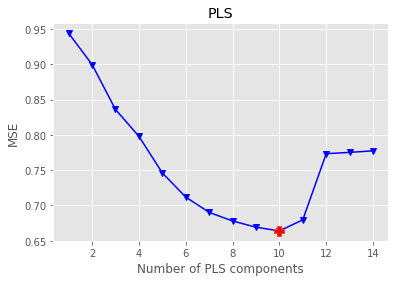

In [33]:
plot_metrics(mses, 'MSE', 'min')

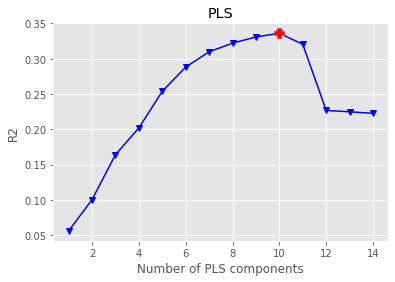

In [34]:
plot_metrics(r2s, 'R2', 'max')

## Prediction from global model

In [35]:
global_pls = PLSRegression(n_components=10)

# Fit
global_pls.fit(X_data, Y_data)

# Cross-validation
y_cv = cross_val_predict(global_pls, X_data, Y_data, cv=10)

# Calculate scores
score = r2_score(Y_data, y_cv)
mse = mean_squared_error(Y_data, y_cv)

In [36]:
score

0.33604584236534124

In [37]:
mse

0.6639541576346587

In [38]:
##predictions

In [39]:
Y_test = Total_Y_data[:1068]
X_test = Total_X_data[:1068]

In [40]:
Y_test.shape

(1068, 9)

In [41]:
X_test.shape

(1068, 250)

In [42]:
Test_X_data = scaler_x.transform(X_test)
Test_Y_data = scaler_y.transform(Y_test)

In [43]:
ypred2 = global_pls.predict(Test_X_data)
print(r2_score(Test_Y_data,ypred2))

0.3251759350330142


In [44]:
names = ['V_myo(um3)', 'V_myo_uL(uL)', 'K_o(millimolar)', 'Na_o(millimolar)',
       'g_Na(microS)', 'g_t(microS)', 'a_endo', 'g_D(um3_per_ms)', 'N']

In [45]:
results_df = pd.DataFrame()
ypred = global_pls.predict(Test_X_data)

extra_results_df = pd.DataFrame([r2_score(Test_Y_data[:,i],ypred[:,i]) for i in range(len(names))],index=names,columns=['r2_score'])
results_df = pd.concat([results_df,extra_results_df],axis=1)
results_df

,r2_score
V_myo(um3),0.138606
V_myo_uL(uL),0.157445
K_o(millimolar),0.820454
Na_o(millimolar),0.352422
g_Na(microS),0.417001
g_t(microS),0.470634
a_endo,0.208388
g_D(um3_per_ms),0.215499
N,0.146134


In [133]:
type(ypred)

numpy.ndarray

In [135]:
type(Test_Y_data)

pandas.core.frame.DataFrame

## Getting global X and Y scores

In [46]:
X_scores = global_pls.x_scores_
Y_scores = global_pls.y_scores_

In [47]:
X_scores.shape

(4276, 10)

In [48]:
Y_scores.shape

(4276, 10)

## Clustering with X_scores

In [49]:
from sklearn.cluster import KMeans

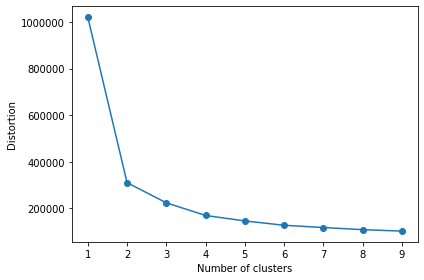

In [52]:
distortions = []
for i in range(1, 10):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    y_km = km.fit(X_scores)
    distortions.append(km.inertia_)
plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()

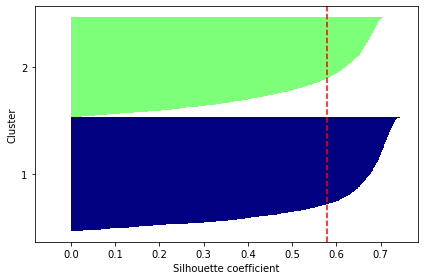

In [53]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

km = KMeans(n_clusters=2, 
            init='k-means++', 
            n_init=10, 
            max_iter=500,
            tol=1e-04,
            random_state=377)
y_km = km.fit_predict(X_scores)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_scores, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()


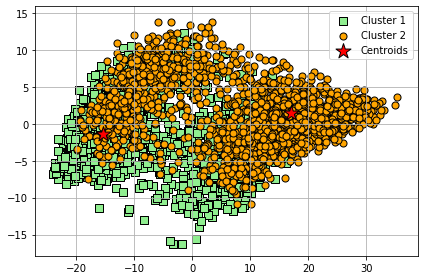

In [54]:
km = KMeans(n_clusters=2, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(Y_scores)


plt.scatter(X_scores[y_km == 0, 0],
            X_scores[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Cluster 1')
plt.scatter(X_scores[y_km == 1, 0],
           X_scores[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Cluster 2')

plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='Centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
#plt.savefig('images/11_02.png', dpi=300)
plt.show()

In [55]:
X_score_df = pd.DataFrame(X_scores)

In [56]:
X_score_df

,0,1,2,3,4,5,6,7,8,9
0,-11.142930,4.781964,-0.119577,1.954262,-2.592212,-0.702935,0.471464,-0.439684,0.333901,-0.278663
1,-12.535466,-2.638563,2.108240,-2.180009,0.224988,0.367304,0.229019,-0.553349,0.096632,0.434911
2,-10.472111,1.150830,1.478918,-1.014536,-1.883989,-0.372306,-0.343798,-0.790333,0.292994,0.094611
3,11.311516,-6.432332,-0.743534,-1.505588,-0.447518,0.634195,-0.309475,0.349229,-0.167286,0.397078
4,-9.305298,5.293404,-1.680599,-2.630480,0.239389,2.110383,-0.233293,0.039071,0.206145,0.444586
...,...,...,...,...,...,...,...,...,...,...
4271,0.712743,-7.822637,0.768106,2.797722,-1.163604,0.936435,-1.346444,1.606582,-0.193942,0.206474
4272,-4.639661,7.609099,-3.087021,-3.303270,1.226828,0.388959,-0.377480,0.052927,1.966052,-0.273031
4273,-14.285638,-3.608515,1.761418,-0.950808,0.668398,-0.607189,-1.207065,0.308360,-0.140662,-0.439401
4274,-12.439750,2.068098,2.162602,1.899748,0.138080,-0.565134,-0.609005,-0.812088,0.256194,-0.063712


In [57]:
X_score_df['Cluster'] = y_km

In [58]:
X_cluster_df = X_score_df

In [59]:
X_cluster_df

,0,1,2,3,4,5,6,7,8,9,Cluster
0,-11.142930,4.781964,-0.119577,1.954262,-2.592212,-0.702935,0.471464,-0.439684,0.333901,-0.278663,1
1,-12.535466,-2.638563,2.108240,-2.180009,0.224988,0.367304,0.229019,-0.553349,0.096632,0.434911,0
2,-10.472111,1.150830,1.478918,-1.014536,-1.883989,-0.372306,-0.343798,-0.790333,0.292994,0.094611,0
3,11.311516,-6.432332,-0.743534,-1.505588,-0.447518,0.634195,-0.309475,0.349229,-0.167286,0.397078,0
4,-9.305298,5.293404,-1.680599,-2.630480,0.239389,2.110383,-0.233293,0.039071,0.206145,0.444586,0
...,...,...,...,...,...,...,...,...,...,...,...
4271,0.712743,-7.822637,0.768106,2.797722,-1.163604,0.936435,-1.346444,1.606582,-0.193942,0.206474,0
4272,-4.639661,7.609099,-3.087021,-3.303270,1.226828,0.388959,-0.377480,0.052927,1.966052,-0.273031,1
4273,-14.285638,-3.608515,1.761418,-0.950808,0.668398,-0.607189,-1.207065,0.308360,-0.140662,-0.439401,0
4274,-12.439750,2.068098,2.162602,1.899748,0.138080,-0.565134,-0.609005,-0.812088,0.256194,-0.063712,0


## Creating 2 dataframes having different cluster labels

In [61]:
X_cluster_1 = X_cluster_df.loc[X_cluster_df['Cluster'] == 1]
X_cluster_0 = X_cluster_df.loc[X_cluster_df['Cluster'] == 0]

## Creating new X and Y dataset for local PLSR

## PLSR 0

In [62]:
X_cluster_0 = pd.DataFrame(X_cluster_0)
Y_data= pd.DataFrame(Y_data)
X_data = pd.DataFrame(X_data)

In [63]:
Y_data_0= Y_data[Y_data.index.isin(X_cluster_0.index)]
X_data_0= X_data[X_data.index.isin(X_cluster_0.index)]

## Following similar procedure for creating X and Y dataset for PLSR 1

In [64]:
X_cluster_1 = pd.DataFrame(X_cluster_1)

In [65]:
Y_data_1= Y_data[Y_data.index.isin(X_cluster_1.index)]
X_data_1= X_data[X_data.index.isin(X_cluster_1.index)]

## Training PLSR 0,1

In [67]:
local_pls_0 = PLSRegression(n_components=10)

# Fit
local_pls_0.fit(X_data_0, Y_data_0)

# Cross-validation
y_cv = cross_val_predict(local_pls_0, X_data_0, Y_data_0, cv=10)

# Calculate scores
score = r2_score(Y_data_0, y_cv)
mse = mean_squared_error(Y_data_0, y_cv)

In [68]:
score

0.2997313477960826

In [69]:
mse

0.6335499298013784

In [70]:
local_pls_1 = PLSRegression(n_components=10)

# Fit
local_pls_1.fit(X_data_1, Y_data_1)

# Cross-validation
y_cv = cross_val_predict(local_pls_1, X_data_1, Y_data_1, cv=10)

# Calculate scores
score = r2_score(Y_data_1, y_cv)
mse = mean_squared_error(Y_data_1, y_cv)

In [71]:
score

0.282889668982827

In [72]:
mse

0.6549878667637178

## Global PLSR predictions

In [73]:
X_test = Total_X_data[:1068]
Y_test = Total_Y_data[:1068]

In [74]:
Test_X_data = scaler_x.transform(X_test)

In [75]:
ypred_global = global_pls.predict(Test_X_data)

## Classification Algorithm with X

In [76]:
target = X_cluster_df.Cluster

In [77]:
X_cluster_df

,0,1,2,3,4,5,6,7,8,9,Cluster
0,-11.142930,4.781964,-0.119577,1.954262,-2.592212,-0.702935,0.471464,-0.439684,0.333901,-0.278663,1
1,-12.535466,-2.638563,2.108240,-2.180009,0.224988,0.367304,0.229019,-0.553349,0.096632,0.434911,0
2,-10.472111,1.150830,1.478918,-1.014536,-1.883989,-0.372306,-0.343798,-0.790333,0.292994,0.094611,0
3,11.311516,-6.432332,-0.743534,-1.505588,-0.447518,0.634195,-0.309475,0.349229,-0.167286,0.397078,0
4,-9.305298,5.293404,-1.680599,-2.630480,0.239389,2.110383,-0.233293,0.039071,0.206145,0.444586,0
...,...,...,...,...,...,...,...,...,...,...,...
4271,0.712743,-7.822637,0.768106,2.797722,-1.163604,0.936435,-1.346444,1.606582,-0.193942,0.206474,0
4272,-4.639661,7.609099,-3.087021,-3.303270,1.226828,0.388959,-0.377480,0.052927,1.966052,-0.273031,1
4273,-14.285638,-3.608515,1.761418,-0.950808,0.668398,-0.607189,-1.207065,0.308360,-0.140662,-0.439401,0
4274,-12.439750,2.068098,2.162602,1.899748,0.138080,-0.565134,-0.609005,-0.812088,0.256194,-0.063712,0


In [78]:
data =X_cluster_df.drop(["Cluster"], axis=1)

In [79]:
data

,0,1,2,3,4,5,6,7,8,9
0,-11.142930,4.781964,-0.119577,1.954262,-2.592212,-0.702935,0.471464,-0.439684,0.333901,-0.278663
1,-12.535466,-2.638563,2.108240,-2.180009,0.224988,0.367304,0.229019,-0.553349,0.096632,0.434911
2,-10.472111,1.150830,1.478918,-1.014536,-1.883989,-0.372306,-0.343798,-0.790333,0.292994,0.094611
3,11.311516,-6.432332,-0.743534,-1.505588,-0.447518,0.634195,-0.309475,0.349229,-0.167286,0.397078
4,-9.305298,5.293404,-1.680599,-2.630480,0.239389,2.110383,-0.233293,0.039071,0.206145,0.444586
...,...,...,...,...,...,...,...,...,...,...
4271,0.712743,-7.822637,0.768106,2.797722,-1.163604,0.936435,-1.346444,1.606582,-0.193942,0.206474
4272,-4.639661,7.609099,-3.087021,-3.303270,1.226828,0.388959,-0.377480,0.052927,1.966052,-0.273031
4273,-14.285638,-3.608515,1.761418,-0.950808,0.668398,-0.607189,-1.207065,0.308360,-0.140662,-0.439401
4274,-12.439750,2.068098,2.162602,1.899748,0.138080,-0.565134,-0.609005,-0.812088,0.256194,-0.063712


In [82]:
train_data, test_data, train_labels, test_labels = train_test_split(data, target, random_state=0, shuffle=True)

In [83]:
test_data.shape

(1069, 10)

In [84]:
train_data.set_index(pd.Series(range(0, 3207)), inplace = True)
test_data.set_index(pd.Series(range(0, 1069)), inplace = True)

In [86]:
import RENT

In [87]:
# Define a range of regularisation parameters C for elastic net. A minimum of at least one value is required.
my_C_params = [0.1, 1, 10]

# Define a reange of l1-ratios for elastic net.  A minimum of at least one value is required.
my_l1_ratios = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

# Define setting for RENT
analysis = RENT.RENT_Classification(data=train_data, 
                                    target=train_labels, 
                                    feat_names=train_data.columns, 
                                    C=my_C_params, 
                                    l1_ratios=my_l1_ratios,
                                    autoEnetParSel=True,
                                    poly='OFF',
                                    testsize_range=(0.25,0.25),
                                    scoring='mcc',
                                    method='logreg',
                                    K=100,
                                    random_state = 0,
                                    verbose=1)

data dimension: (3207, 10)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension (3207,)
regularization parameters C: [0.1, 1, 10]
elastic net l1_ratios: [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
number of models in ensemble: 100
scale: True
classification method: logreg
random state: 0
verbose: 1


In [88]:
analysis.train()

In [89]:
analysis.get_runtime()

2.0123703479766846

In [90]:
analysis.get_enet_params()

(0.1, 1.0)

In [91]:
selected_features = analysis.selectFeatures(tau_1_cutoff=0.9, tau_2_cutoff=0.9, tau_3_cutoff=0.975)

In [92]:
analysis.summary_criteria()

,0,1,2,3,4,5,6,7,8,9
tau_1,1.0,1.0,1.0,1.0,1.0,0.99,0.310000,1.0,1.0,0.230000
tau_2,1.0,1.0,1.0,1.0,1.0,0.99,0.230000,1.0,1.0,0.070000
tau_3,1.0,1.0,1.0,1.0,1.0,1.00,0.999963,1.0,1.0,0.777058


In [93]:
selected_features

array([0, 1, 2, 3, 4, 5, 7, 8], dtype=int64)

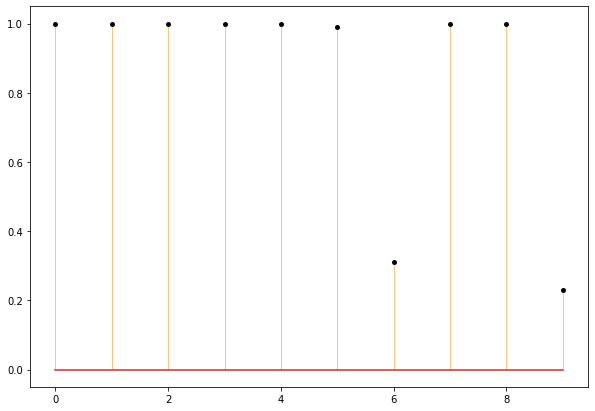

In [94]:

analysis.plot_selection_frequency()

In [95]:

# Import what is needed for prediction and evaluation of predictions from test set
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LR

# Scale the data accordingly
sc = StandardScaler()
train_data_sc = sc.fit_transform(train_data.iloc[:, selected_features])
test_data_sc = sc.transform(test_data.iloc[:, selected_features])

# Train model with 
model = LR(penalty='none', max_iter=8000, solver="saga", random_state=0).\
        fit(train_data_sc, train_labels)

# Print results
print("f1 1: ", f1_score(test_labels, model.predict(test_data_sc)))
print("f1 0: ", f1_score(1 - test_labels, 1 - model.predict(test_data_sc)))
print("Accuracy: ", accuracy_score(test_labels, model.predict(test_data_sc)))
print("Matthews correlation coefficient: ", matthews_corrcoef(test_labels, model.predict(test_data_sc)))

f1 1:  0.8103448275862069
f1 0:  0.8190127970749543
Accuracy:  0.8147801683816651
Matthews correlation coefficient:  0.6293576246611612


In [96]:
analysis.summary_objects()

,# test,class,# incorrect,% incorrect
0,28,1,0,0.000000
1,22,0,22,100.000000
2,27,1,27,100.000000
3,28,1,0,0.000000
4,30,0,0,0.000000
...,...,...,...,...
3202,34,0,34,100.000000
3203,24,0,0,0.000000
3204,26,0,26,100.000000
3205,22,0,21,95.454545


loo


TypeError: 'numpy.ndarray' object is not callable

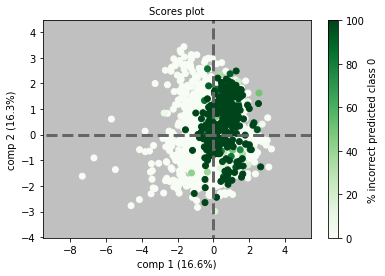

In [97]:
analysis.plot_object_PCA(cl=0)

loo


TypeError: 'numpy.ndarray' object is not callable

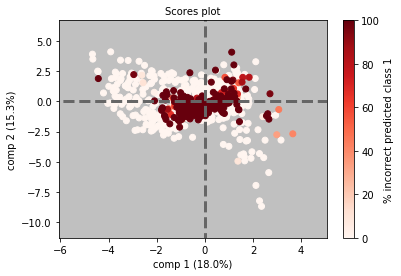

In [98]:
analysis.plot_object_PCA(cl=1)

mean VS1 0.40176854645242466
VS1: p-value for average score from random feature drawing:  3.695977019847596e-17
With a significancelevel of  0.05  H0 is rejected.
 
-----------------------------------------------------------
 
Mean VS2 4.056609720733778e-05
VS2: p-value for score from permutation of test labels:  0.0
With a significancelevel of  0.05  H0 is rejected.


TypeError: 'numpy.ndarray' object is not callable

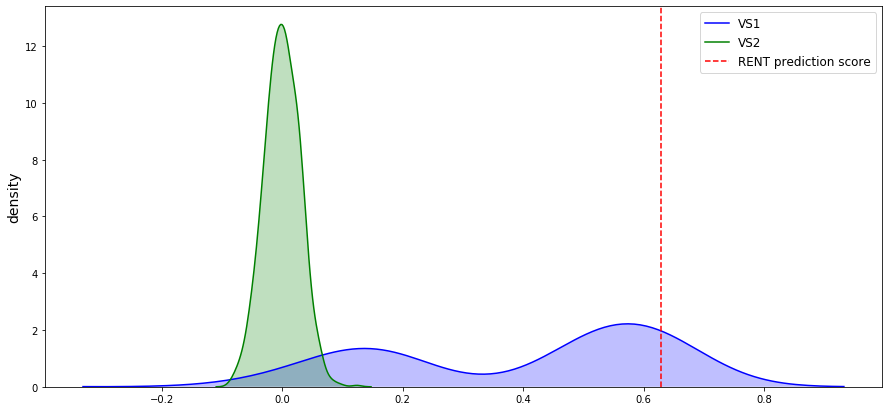

In [99]:
analysis.validation_study(test_data, test_labels, num_drawings=100, num_permutations=1000, alpha=0.05)

## Training Logistic Regression Model with All Data

In [100]:
sc_X_score = StandardScaler().fit(data.iloc[:, selected_features])

sc_X_score_scaled = sc_X_score.transform(data.iloc[:, selected_features])



In [101]:
model_lr = LR(penalty='none', max_iter=8000, solver="saga", random_state=0).\
        fit(sc_X_score_scaled, target)


## Classifying the X_scores data

In [108]:
global_x_weights = global_pls.x_weights_

In [109]:
X_scores_proj = np.dot(Test_X_data,global_x_weights)

In [110]:
X_scores_proj_class= pd.DataFrame(X_scores_proj[:, selected_features])

In [112]:
pred_lr = model_lr.predict(X_scores_proj_class)

In [113]:
projected_X_scores = pd.DataFrame(X_scores_proj)

In [114]:
projected_X_scores['Cluster'] = pred_lr

In [115]:
projected_X_scores

,0,1,2,3,4,5,6,7,8,9,Cluster
0,0.760019,0.399028,3.079378,1.526640,-1.040910,1.955477,-0.867980,0.601442,0.653104,0.649220,1
1,2.409426,-7.047064,0.252595,0.608659,0.137465,-0.411229,1.196204,-0.867578,0.025890,1.112511,0
2,-19.544050,-0.671981,-1.979705,-0.114011,-0.641198,-0.543261,0.159112,0.861948,0.123319,-0.870482,0
3,12.084989,-3.551195,-2.698418,-0.875788,0.941739,0.393687,-0.610000,-0.144539,-0.393758,0.234665,1
4,-0.161241,9.442198,-0.586076,-2.086532,1.783358,1.198352,-0.115344,0.495431,-1.041967,-1.117832,1
...,...,...,...,...,...,...,...,...,...,...,...
1063,-3.388821,9.217367,-4.599690,-6.250857,5.602880,-2.770064,1.085687,-0.735158,0.942468,0.904060,1
1064,17.350585,-4.076904,3.139095,-1.053639,-0.247614,0.757100,0.482242,0.748153,-0.235802,-0.339647,1
1065,12.448377,-0.974862,0.628336,3.660617,-0.348864,0.128924,-0.930340,-0.400956,-0.505224,-0.450371,1
1066,12.753530,-2.028335,-4.555983,0.653746,-0.408813,-1.031506,-0.161303,-0.044247,0.210265,-0.944128,1


## Extracting class label 0,1

In [116]:
X_scores_0 = projected_X_scores.loc[projected_X_scores['Cluster'] == 0].drop(["Cluster"],axis=1)
X_scores_1 = projected_X_scores.loc[projected_X_scores['Cluster'] == 1].drop(["Cluster"],axis=1)

In [117]:
Test_X_data = pd.DataFrame(Test_X_data)
Test_Y_data = pd.DataFrame(Test_Y_data)

In [118]:
Test_X_data_0= Test_X_data[Test_X_data.index.isin(X_scores_0.index)]
Test_X_data_1= Test_X_data[Test_X_data.index.isin(X_scores_1.index)]

In [119]:
Test_Y_data_0 = Test_Y_data[Test_Y_data.index.isin(X_scores_0.index)]
Test_Y_data_1 = Test_Y_data[Test_Y_data.index.isin(X_scores_1.index)]

In [120]:
##predictions

In [121]:
pred_0 = local_pls_0.predict(Test_X_data_0)
pred_1 = local_pls_1.predict(Test_X_data_1)

In [122]:
all_pred = np.concatenate([pred_0, pred_1])

In [123]:
all_pred.shape

(1068, 9)

In [124]:
## Appending Truth values Y_test 

In [125]:
Y_test_sequential = pd.concat([Test_Y_data_0, Test_Y_data_1])

In [126]:
print(r2_score(Y_test_sequential,all_pred))

0.31984040051673535


In [129]:
Y_test_sequential.shape

(1068, 9)

In [136]:
type(all_pred)

numpy.ndarray

In [144]:
results_df = pd.DataFrame()


extra_results_df = pd.DataFrame([r2_score(Y_test_sequential.loc[:,i],all_pred[:,i]) for i in range(len(names))],index=names,columns=['r2_score'])
results_df = pd.concat([results_df,extra_results_df],axis=1)
results_df

,r2_score
V_myo(um3),0.106976
V_myo_uL(uL),0.157750
K_o(millimolar),0.821575
Na_o(millimolar),0.357790
g_Na(microS),0.440396
g_t(microS),0.494651
a_endo,0.212514
g_D(um3_per_ms),0.206514
N,0.080399
